In [1]:
# Imports
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy import stats
import os
from deproject import deproject, get_galaxy_specs

In [2]:
# This is a manual version of the AutoHistogram script that allows creation of 
# galaxy masks and blanking out parts of the image before computing histogram
dir = '/home/jackson/galaxies/' # directory containing folders containing galaxy fit files
galaxy = 'NGC4548' # name of folder to look in
RA, DEC, POSANG, INCL, DIST = get_galaxy_specs(galaxy) # DIST [Mpc]
fileName = 'ngc4548_w1_atGauss15.fits' # file name
fitsFile = fits.getdata(dir + galaxy + '/' + fileName).flatten() # Just change the last part of this string to change file
fitsRaw = fits.open(dir + galaxy + '/' + fileName)

wisemid = fits.getdata(dir + galaxy + '/ngc4548_w1_atGauss15.fits')
iracmid = fits.getdata(dir + galaxy + '/ngc4548_irac1_atGauss15.fits')
wiseout = fits.getdata(dir + galaxy + '/ngc4548_w1_atGauss15.fits')
iracout = fits.getdata(dir + galaxy + '/ngc4548_irac1_atGauss15.fits')

hdu_galxw = fits.open(dir + galaxy + '/ngc4548_w1_atGauss15.fits')[0]
wcs_galxw = WCS(hdu_galxw.header)
wcs_galxw.sip = None
deproj_imgw = deproject(center_coord=(RA*u.deg, DEC*u.deg), incl=INCL*u.deg, pa=POSANG*u.deg,
                           header=hdu_galxw.header, wcs=None, naxis=None, ra=None, dec=None,
                           return_offset=False)

hdu_galxi = fits.open(dir + galaxy + '/ngc4548_irac1_atGauss15.fits')[0]
wcs_galxi = WCS(hdu_galxi.header)
wcs_galxi.sip = None
deproj_imgi = deproject(center_coord=(RA*u.deg, DEC*u.deg), incl=INCL*u.deg, pa=POSANG*u.deg,
                           header=hdu_galxi.header, wcs=None, naxis=None, ra=None, dec=None,
                           return_offset=False)

r_degw = deproj_imgw[0]
r_pcw = r_degw * (np.pi / 180) * (DIST * 1e6) # in pc

r_degi = deproj_imgi[0]
r_pci = r_degi * (np.pi / 180) * (DIST * 1e6) # in pc

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

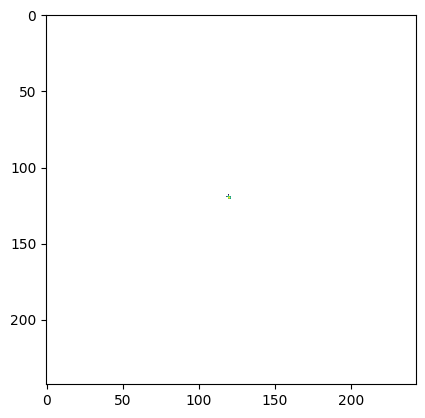

In [9]:
# r_pc = r_deg * (np.pi / 180) * (DIST * 1e6) # in

maskwmid = (r_pcw < 5*1e2)
maskedwmid = r_pcw.copy()
maskedwmid[~maskwmid] = np.nan
wisemid[~maskwmid] = np.nan
plt.imshow(wisemid)


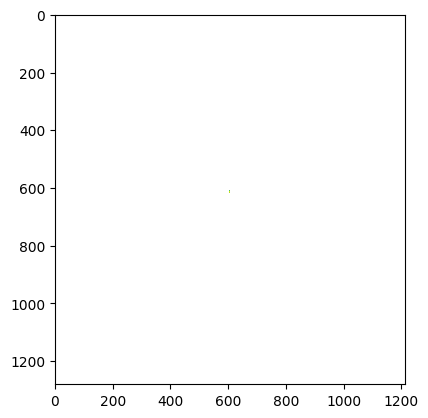

In [10]:
maskimid = (r_pci < 5*1e2)
maskedimid = r_pci.copy()
maskedimid[~maskimid] = np.nan
iracmid[~maskimid] = np.nan
plt.imshow(iracmid)

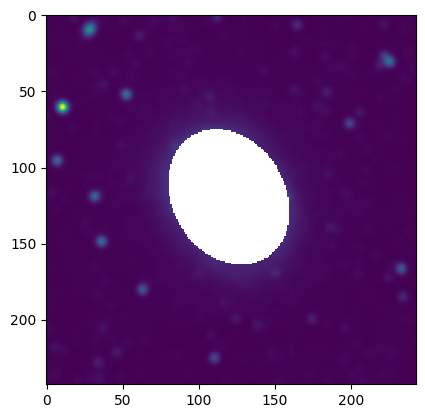

In [11]:
maskwout = (r_pcw > 125*1e2)
maskedwout = r_pcw.copy()
maskedwout[~maskwout] = np.nan
wiseout[~maskwout] = np.nan
plt.imshow(wiseout)

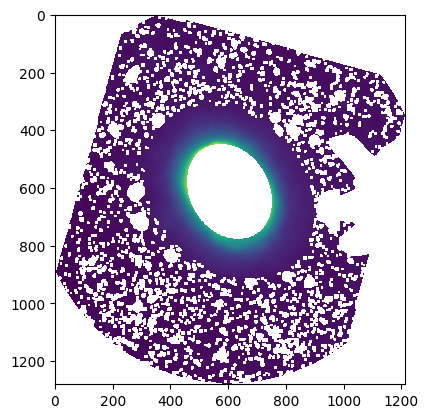

In [12]:
maskiout = (r_pci > 125*1e2)
maskediout = r_pci.copy()
maskediout[~maskiout] = np.nan
iracout[~maskiout] = np.nan
plt.imshow(iracout)


Mean of ngc4548_w1_atGauss15.fits: 0.05782057769150212

Median of ngc4548_w1_atGauss15.fits: 0.00806081508894511

Mode of ngc4548_w1_atGauss15.fits: ModeResult(mode=-0.004060583659840227, count=1)


(0.05782057769150212,
 0.00806081508894511,
 ModeResult(mode=-0.004060583659840227, count=1))

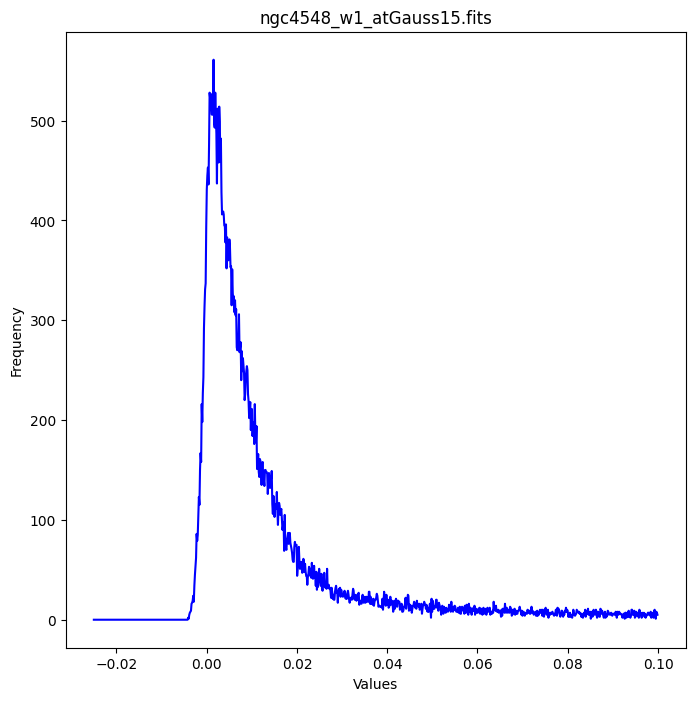

In [13]:
# vars to edit
saveFigs = False
saveStats = False # save histograms stats like mean, median, mode
saveDir = dir # this will save figures to the root directory of galaxies folder in folder called 'figs' - change this if you want it saved elsewhere
color = 'blue'
minclip = -.025
maxclip = .1
bincount = 1000
figx = 8
figy = 8
xlabel = 'Values'
ylabel = 'Frequency'
maskGalaxy = True

# update fits files to change galaxy to NAN
#def galaxyMask():
    

# make directory to store figs if it doesn't exist
if (saveFigs or saveStats):
    if (not os.path.isdir(dir + '/figs/')):
        os.mkdir(dir + '/figs/')

# open/create text file to store histogram statistics
if (saveStats == True):
    if (not os.path.isfile(dir + '/figs/stats.txt')):
        statsFile = open(dir + '/figs/stats.txt', 'x')
    else:
        statsFile = open(dir + '/figs/stats.txt', 'a')

# function to save figs
def saveFig(name):
    plt.savefig(dir + '/figs/' + name + '.png')

# function to calculate mean, median, mode and print to file
def calcMMM(wdata, name, wraw):
    mean = np.mean(wdata)
    meanString = "\nMean of " + name + ": " + str(mean)
    print(meanString)
    median = np.median(wdata)
    medianString = "\nMedian of " + name + ": " + str(median)
    print(medianString)
    mode = stats.mode(wdata)
    modeString = "\nMode of " + name + ": " + str(mode)
    print(modeString)
    if (saveStats == True):
        statsFile.write(meanString)
        statsFile.write(medianString)
        statsFile.write(modeString)
        statsFile.write('\n')
#    if (writeMMMToFits):
#        hdr = wraw[0].header
#        hdr.set('mean', mean)
#        hdr.set('median', median)
#        hdr.set('mode', mode)
#        wraw.close()
    return mean, median, mode

def createFig1(data, figx, figy, xlabel, ylabel, bins, color, name):
    f = plt.figure(figsize=(figx, figy))
    Y, BE = np.histogram(data, bins=bins)
    X = BE[:-1]
    plt.plot(X, Y, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(name)
    if (saveFigs == True):
        saveFig(name)
    return X, Y

bins=np.linspace(minclip, maxclip, bincount)
X, Y = createFig1(fitsFile, figx, figy, xlabel, ylabel, bins, color, fileName)
# Calculate mean, median, mode, and save the figure
calcMMM(fitsFile, fileName, fitsRaw)